**Assumptions:**
1. Allow short (total max 500m "As the Crows Flies") walking distances for transfers between two stops, and assume a walking speed of 50m/1min on a straight line, regardless of obstacles, human-built or natural, such as building, highways, rivers, or lakes.
2. Not consider numerous stops listed under names such as 8501117:0:3 and 8501117:0:4 (need modification)
3. Not consider to keep trip_id consistent although they are the same path (need modification)
4. Not consider stops not recorded in data (istdaten_available is false) (need modification)
5. Two hour reachable area (change to definition of approximate boundaries like the 15km area)
6. On Monday calender (extend to reasonable hours of the day, and on a typical business day, and assuming a recent schedule.)
7. Simple visualization (need more interactive visualization using ipywidgets and also easier for our validation.)

In [21]:
import pandas as pd
import numpy as np
import networkx as nx
import heapq

from util import minutes_to_hours, time_to_minutes

In [26]:
df = pd.read_csv("/home/jovyan/homework2/data/stop_times.csv", index_col=0)
stops_lausanne_all = pd.read_csv("/home/jovyan/homework2/data/stops.csv", index_col=0)
stops_to_stops = pd.read_csv("/home/jovyan/homework2/data/stop_to_stop.csv", index_col=0)
df.columns = ['trip_id', 'stop_id', 'departure_time', 'arrival_time']
stops_lausanne_all.columns = ['stop_id', 'stop_name','stop_lat','stop_lon']
stops_to_stops.columns = ['stop_id_a', 'stop_id_b', 'distance']

In [6]:
# set start time and start stop
start_time = time_to_minutes("12:00:00")
start_stop = '8591818'

In [7]:
# calculate the time in minute
df['departure_time_mins'] = df['departure_time'].apply(time_to_minutes)
df['arrival_time_mins'] = df['arrival_time'].apply(time_to_minutes)

# df filtered
df_filtered = df[(df['arrival_time_mins'] >= start_time) & (df['arrival_time_mins'] <= start_time+120.0)]
df_filtered.sort_values(by=['trip_id', 'arrival_time_mins', 'departure_time_mins'], inplace=True)
df_filtered.reset_index(inplace=True)
df_filtered.head()

/tmp/ipykernel_541/686408745.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.sort_values(by=['trip_id', 'arrival_time_mins', 'departure_time_mins'], inplace=True)


index                trip_id  stop_id departure_time arrival_time  \
0    195  1.TA.96-240-j24-1.1.H  8570064       13:36:00     13:36:00   
1    196  1.TA.96-240-j24-1.1.H  8570063       13:40:00     13:40:00   
2    197  1.TA.96-249-j24-1.7.H  8570178       12:59:00     12:59:00   
3    227  1.TA.96-65-j24-1.11.H  8511210       12:21:00     12:21:00   
4    228  1.TA.96-65-j24-1.11.H  8511214       12:23:00     12:23:00   

   departure_time_mins  arrival_time_mins  
0                816.0              816.0  
1                820.0              820.0  
2                779.0              779.0  
3                741.0              741.0  
4                743.0              743.0

In [8]:
G = nx.MultiDiGraph()

# add edges by taking transportation
for _, row in df_filtered.iterrows():
    if _ + 1 < len(df_filtered) and df_filtered.loc[_ + 1, 'trip_id'] == row['trip_id']:
        next_stop = df_filtered.loc[_ + 1, 'stop_id']
        arr_time_next_stop = df_filtered.loc[_ + 1, 'arrival_time_mins']
        travel_time = row['departure_time_mins']-arr_time_next_stop

        try:
            distance = stops_to_stops[(stops_to_stops['stop_id_a'] == row['stop_id']) & (stops_to_stops['stop_id_b'] == next_stop)]['distance']
        except:
            distance = np.inf
        
        G.add_edge(row['stop_id'], next_stop, weight=travel_time, trip_id=row['trip_id'], 
                   departure_time_mins=row['departure_time_mins'], 
                   arrival_time_mins=arr_time_next_stop,
                   walking_time = round(distance/50,0))

In [9]:
# add edges by only walking 
for _, row in stops_to_stops.iterrows():
    n1, n2 = row['stop_id_a'], row['stop_id_b']
    if G.has_edge(n1, n2):
        distance = row['distance']
        G.add_edge(n1, n2, weight=round(distance/50), trip_id="walking", 
                   departure_time_mins=0, 
                   arrival_time_mins=np.inf,
                   walking_time = round(distance/50))

In [20]:
def modified_dijkstra(G, source, start_time):
    # Dictionary to store minimum arrival times for each site
    min_arrival_time = {node: np.inf for node in G.nodes()}
    min_arrival_time[source] = start_time

    # priority queues, storage (arrival times, stations)
    priority_queue = [(start_time, source)]
    
    # dictionary records the best precursor node to reach each site and the itinerary used
    predecessor = {node: None for node in G.nodes()}
    
    while priority_queue:
        current_time, current_stop = heapq.heappop(priority_queue)

        # iterate over all trips from the current station
        for neighbor in G[current_stop]:
            for key, edge_attr in G[current_stop][neighbor].items():
                departure_time = edge_attr['departure_time_mins']
                arrival_time = edge_attr['arrival_time_mins']
                walking_time = edge_attr['walking_time']
                trip_id = edge_attr['trip_id']
                if trip_id != 'walking':
                    travel_time = arrival_time - departure_time
                    wait_time = max(0, departure_time - current_time)
                else: 
                    travel_time = walking_time
                    wait_time = 0
                total_time = current_time + wait_time + travel_time
                
                # Update and add stations to the queue only if the newly calculated arrival time is shorter than the known arrival time
                if total_time < min_arrival_time[neighbor] and departure_time >= current_time:
                    min_arrival_time[neighbor] = total_time
                    predecessor[neighbor] = (current_stop, minutes_to_hours(current_time), trip_id)
                    heapq.heappush(priority_queue, (total_time, neighbor))
    
    return min_arrival_time, predecessor

def reconstruct_path(predecessor, start, end):
    path = []
    step = end
    while step != start:
        if predecessor[step] is None:
            return None
        try:
            stop_name = stops_lausanne_all[stops_lausanne_all['stop_id'] == predecessor[step][0]]['stop_name'].values[0]
        except:
            stop_name = ''
        path.append((predecessor[step][0], stop_name, predecessor[step][1], predecessor[step][2])) 
        step = predecessor[step][0]
    path.reverse()
    return path

In [22]:
min_arrival_time, predecessor = modified_dijkstra(G, start_stop, start_time)

In [28]:
source = start_stop
end = '8579238:0:D'
path = reconstruct_path(predecessor, source, end)
print("Path from", source, "to", end, ":")
for e in path:
    print(e[0], e[1], e[2], e[3])
print(end, stops_lausanne_all[stops_lausanne_all['stop_id'] == end]['stop_name'].values[0])

Path from 8591818 to 8579238:0:D :
8591818 Lausanne-Flon, pl. de l'Europe 12:0 1556.TA.91-m2-j24-1.2.H
8590442 Lausanne, Riponne-M. Béjart 12:4 1556.TA.91-m2-j24-1.2.H
8589523 Lausanne, Bessières 12:5 1556.TA.91-m2-j24-1.2.H
8579237 Lausanne, Ours 12:7 1556.TA.91-m2-j24-1.2.H
8592017  12:9 1556.TA.91-m2-j24-1.2.H
8579238 Lausanne, Sallaz 12:10 323.TA.92-6-Q-j24-1.13.H
8592118 Lausanne, St-Etienne 12:16 323.TA.92-6-Q-j24-1.13.H
8592127 Lausanne, Valmont 12:17 323.TA.92-6-Q-j24-1.13.H
8579245 Lausanne, Foyer 12:18 15.TA.96-287-j24-1.9.H
8579238:0:D Lausanne, Sallaz


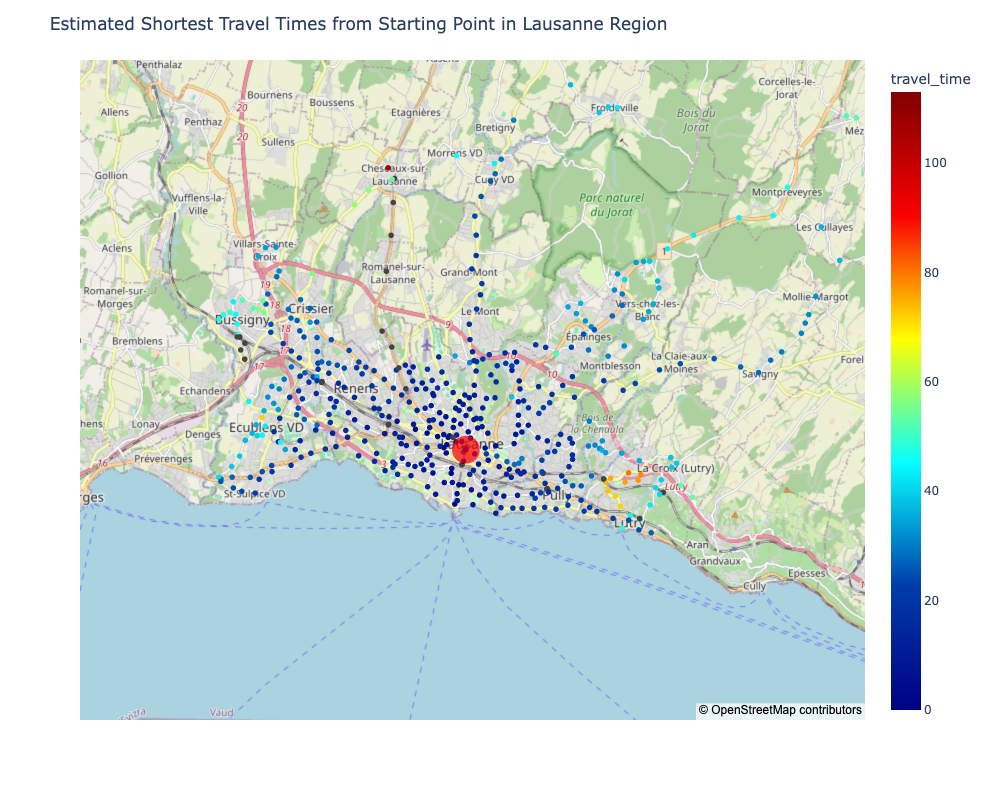

In [29]:
distances_df = pd.DataFrame(list(min_arrival_time.items()), columns=['stop_id', 'travel_time_mins'])
distances_df['travel_time'] = distances_df['travel_time_mins'] - start_time
# distances_df = distances_df[distances_df['travel_time'] <= 30]

stops_with_travel_time = pd.merge(stops_lausanne_all, distances_df, on='stop_id')

fig = px.scatter_mapbox(stops_with_travel_time, lat="stop_lat", lon="stop_lon", hover_name="stop_name",
                        hover_data={"stop_id": True, "travel_time": True},
                        color="travel_time",
                        color_continuous_scale=px.colors.sequential.Jet,  
                        size_max=15, zoom=11,
                        mapbox_style="open-street-map")

# Highlight the start stop by adding a distinct marker
fig.add_trace(px.scatter_mapbox(stops_with_travel_time[stops_with_travel_time['stop_id'] == start_stop],
                                lat="stop_lat", lon="stop_lon",
                                size=[15],  # Larger size for the start stop
                                color_discrete_sequence=["red"]  # Distinct color
                                ).data[0])

fig.update_layout(title="Estimated Shortest Travel Times from Starting Point in Lausanne Region")
fig.update_layout(height=800, width=1200)
fig.show()